# PageRank

<br>
<br>
<center>
<img src="images/Page-et-Brin.jpeg" alt="Larry Page and Sergey Brin" width="450">
<br>
Larry Page and Sergey Brin


<div style="visibility: hidden"> 
Source:
http://pixshark.com/sergey-brin-and-larry-page.htm
</div>

In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import laUtilities as ut
import slideUtilities as sl
import demoUtilities as dm
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
reload(dm)
reload(ut)
reload(sl)
print ''

In [14]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

Today we'll study an algorithm that is probably important in your life: Google's PageRank.

By way of history: the World Wide Web starting becoming widely used in 1994.  By 1998 the Web had become an indispensable information resource. 

However, the problem of effectively searching the Web for relevant information was not well addressed.  A number of large search engines were available, with names that are now forgotten: Alta Vista, Lycos, Excite, and others. 

At present, most of them are no longer in existence, because Google emerged in 1998 and came to dominate Web search almost overnight.

How did this happen?

As background: a typical search engine uses a two-step process to retrieve pages related to a user’s query. 

In
the first step, basic text processing is done to find all documents that contain the query terms. 
Due to the massive size of the Web, this first step can result in many thousands of retrieved pages related to the query.   

Some of these pages are important, but most are not.

The problem that Google solves better than the search engines of the mid 1990’s concerns the __ordering__ in which the resulting search results are presented.  This is the crucial factor in utility.  A user wants to find the "correct" or "best" item at the top of the search results.

By displaying the most relevant pages at the top of the list returned each query, Google makes its search results very useful. The algorithm that gave Google this advantage is called PageRank.

__The Insight__

Around 1998, the limitations of standard search engines, which just used term frequency, we becoming apparent.   A number of researchers were thinking about using additional sources of information to "rate" pages.

The key idea that a number of researchers hit on was this: _links are endorsements._  

When a first page contains a link to a second page, that is an indication that the author of the first page thinks the second page is worth looking at.  If the first and second pages both contain the same query terms, it is likely that the second page is an important page with respect to that query term.

Consider a set of web pages, for a single query term (say "car manufacturers") with this linking structure:

<center>
<img src="images/hub-authority.png" alt="Hubs" width="370">

It may be clear that the links between pages contain useful information.  But what is the best way to extract that information in the form of rankings?

Here is the strategy that Brin and Page used:

From _“The PageRank citation ranking: Bringing order to the Web”_ (1998):
> PageRank can be thought of as a model of user behavior. We assume there is a “random surfer” who is given a web page at random and keeps clicking on links, never hitting “back” but eventually gets bored and starts on another random page. The probability that the random surfer visits a page is its PageRank.

Today we'll study this algorithm, see how to implement it, and understand that what it is really about is Markov Chains and eigenvectors.

## Random Walks

We start with the notion of a __random walk.__

A random walk is a model of many sorts of processes that occur on graphs.

Let us fix a graph $G$.  A random walk (sometimes called a "drunkard's walk") models the movement of an object on this graph.

We assume that the object moves from node to node in $G$, one move per time step $t.$  At time $t$ the object is at node $k$ (say) and at the next time $t+1$ it moves to another node chosen __at random__ from among the outgoing edges.

For our initial discussion, we will assume that $G$ is the line graph:

<center>
<img src="images/Lay-fig-10-3.jpg" alt="Line Graph" width="450">

This is a graph in which each node is connected to two neighbors.  It's natural to identify the nodes with the integers $k = 1,\dots,n.$

What happens at the endpoints of the graph (nodes 1 and $n$) must be specified.

One possibility is for the object to remain fixed at that location.   This is called a __random walk with absorbing boundaries.__

Another possibility is for the object to bounce back one unit when an endpoint is reached.   This is called a __random walk with reflecting boundaries.__

We can also set a particular probability $1-p$ of moving "to the right" (from $k$ to $k+1$) and $p$ of moving "to the left" (from $k$ to $k-1$).

We can capture the process of movement on $G$ as a Markov Chain.  

As a reminder, recall these facts about a Markov Chain.

For a Markov Chain having transition matrix $P$:

* The largest eigenvalue of $P$ is 1.
* If $P$ is regular, then 
    * There is only one eigenvalue equal to 1
    * The chain will converge to the corresponding eigenvector as its _unique steady-state._
* "$P$ is regular" means that for some $k>0$, all entries in $P^k$ are nonzero.


__Example.__  A random walk on $\{1,2,3,4,5\}$ with absorbing boundaries has a transition matrix of 

$$P=\mat{{ccccc}1&p&0&0&0\\0&0&p&0&0\\0&1-p&0&p&0\\0&0&1-p&0&0\\0&0&0&1-p&1}$$

<center>
<img src="images/Lay-fig-10-3.jpg" alt="Line Graph" width="450">

__Example.__ ("Gambler's Ruin").   Consider a very simple casino game.  A gambler (with some money to lose) flips a coin and calls heads or tails.  If the gambler is correct, she wins a dollar.  If she is wrong, she loses a dollar.  The gambler will quit the game when she has either won $n$ dollars or lost all of her money.

Suppose that $n=7$ and the gambler starts with \$4.  The gambler's winnings must move up or down one dollar with each coin flip, and once the gambler's winnings reach 0 or 7, they do not change any more since the gambler has quit the game.  

Such a process may be modeled as a random walk on $\{0,1,2,3,4,5,6,7\}$ with absorbing boundaries.   Since a move up or down is equally likely in this case, $p = 1/2$.

This transition matrix is not regular, and there is not a single steady-state to which the chain surely converges.   

However there are two steady-states, each corresponding to absorption at one boundary, and the chain will surely converge to one or the other.

For example, if $p=0.45$, we find that the probability that the gambler will lose all her money to be $0.4$.

In [15]:
sl.hide_code_in_slideshow()
p = 0.45
A = np.array([[1,p,0,0,0],[0,0,p,0,0],[0,1-p,0,p,0],[0,0,1-p,0,0],[0,0,0,1-p,1]])
B = A.copy()
for i in range(100):
    B = A.dot(B)
# print B.dot(np.array([0,0,1,0,0]))

Now let's consider a random walk on a more interesting graph:

<img src="images/Lay-fig-10-4.jpg" alt="Another Graph" height="200">

Again, at each node there is an equal probability of departing to any adjacent node. 

The transition matrix associated with a random walk on this graph is

$$P = \mat{{ccccccc}
0&1/3&1/4&0&0&0&0\\
1/2&0&1/4&0&1/2&0&0\\
1/2&1/3&0&1&0&1/3&0\\
0&0&1/4&0&0&0&0\\
0&1/3&0&0&0&1/3&0\\
0&0&1/4&0&1/2&0&1\\
0&0&0&0&0&1/3&0}$$

It turns out that this matrix is regular ($P^3$ has no zero entries.)

Hence, the associated Markov Chain converges to a single steady state.  (It has only one eigenvalue of 1.)

The eigenvector corresponding to the eigenvalue of 1 is the steady-state of the Markov Chain.

Hence we can find that the steady-state is $\frac{1}{16}\mat{{c}2\\3\\4\\1\\2\\3\\1}.$    

That is, the probability of bring in node 1 at steady state is 2/16;  the probability of being in node 2 is 3/16;  the probability of being in node 3 is 4/16, etc.

Notice anything?  (Look at $G$ again).

<img src="images/Lay-fig-10-4.jpg" alt="Another Graph" height="200">

It can be proved that the steady-state distribution of a random walk on an undirected graph is proportional to node degree. 

That is, the probability of being at a particular node at steady state is proportion to that node's degree.

In [16]:
sl.hide_code_in_slideshow()
A = np.array([
[0,1./3,1./4,0,0,0,0],
[1./2,0,1./4,0,1./2,0,0],
[1./2,1./3,0,1,0,1./3,0],
[0,0,1./4,0,0,0,0],
[0,1./3,0,0,0,1./3,0],
[0,0,1./4,0,1./2,0,1],
[0,0,0,0,0,1./3,0]])
w,v = np.linalg.eig(A)
# print v[:,0]*(20./3)

Another interesting object on which to walk randomly is a __directed__ graph.  In this graph, all edges are "one-way streets" -- nodes are joined not by lines but by arrows.   The chain can move from vertex to vertex, but only in the directions allowed by the arrows.

An example of a directed graph is


<img src="images/deeper-pagerank-fig.jpg" alt="Directed Graph" height="200">

The transition matrix for this graph is:

$$P = \mat{{cccccc}
0&0&1/3&0&0&0\\
1/2&0&1/3&0&0&0\\
1/2&0&0&0&0&0\\
0&0&0&0&1/2&1\\
0&0&1/3&1/2&0&0\\
0&0&0&1/2&1/2&0
}$$

We can conclude that this matrix is __not__ regular.   Why?

One reason we can conclude this is the column of zeros (column 2).  Any power of $A$ will preserve this column of zeros.

## PageRank

There are many ways to make use of the link structure to infer which pages are most important to return at the top of the search results.  (There was a lot of experimentation in the late 1990s with various methods).

A simple method is just to consider a page is "important" if many "important" pages link to it.

More precisely, this definition of "importance" is:

$$\mbox{Importance of page $k$} = \sum_j \mbox{(Importance of page $j$)}\cdot\mbox{(Probability of going from page $j$ to page $k$.)}$$

This can be captured in terms of a random walk.  

Now we are ready to understand what Page and Brin were saying in 1998:

> PageRank can be thought of as a model of user behavior. We assume there is a “random surfer” who is given a web page at random and keeps clicking on links, never hitting “back” but eventually gets bored and starts on another random page. The probability that the random surfer visits a page is its PageRank.

Intuitively, the a random surfer should spend more time at "important" pages and less time at unimportant pages.

The way to interpret this precisely is:

1) Form the graph that encodes the connections between Web pages that are retrieved for a particular query. 

2) Construct a Markov chain that corresponds to a random walk on this graph.

3) Rank-order the pages according to their probability in the Markov chain's steady state.

So let's try to make this work and see what happens.

__Example.__   Assume a set of Web pages have been selected based on a text query, eg, pages related to "personal 737 jets."

These pages have various links between them, as represented by this graph:

<img src="images/deeper-pagerank-fig.jpg" alt="Directed Graph" height="200">

Construct the unique steady-state distribution for a random walk on this graph, if it exists.  That is, construct the PageRank for this set of Web pages.

__Solution.__

The key question we must ask is __whether a unique steady state exists.__

__Step 1.__  

Assume there are $n$ pages to be ranked.  Construct an $n\times n$ transition matrix for the Markov chain.

Set the Markov chain transitions so that each outgoing link from a node has equal probability of being taken.

We have already seen the transition matrix for this graph:

$$P = \mat{{cccccc}
0&0&1/3&0&0&0\\
1/2&0&1/3&0&0&0\\
1/2&0&0&0&0&0\\
0&0&0&0&1/2&1\\
0&0&1/3&1/2&0&0\\
0&0&0&1/2&1/2&0
}$$

We have observed that this transition matrix is __not__ regular, because for any $A^k, k>0,$ the second column will  be zero.

To address this, let's ask why it happens.   

The reason that column 2 of $P$ is zero is that the Web page corresponding to node 2 has no links embedded in it, so there is nowhere to go from this page.   Of course this will happen a lot in an arbitrary collection of Web pages.

Note that Page and Brin say that the random surfer will occasionally "start on another random page."   In other words, it seems reasonable that when reaching a page with no embedded links, the surfer chooses another page at random.

So this motivates the first adjustment to $P$:

__Step 2:__

Form the matrix $P'$ as follows:  for each column in $P$ that is entirely zeros, replace it with a column in which each entry is $1/n$.

In our example:

$$P = \mat{{cccccc}
0&0&1/3&0&0&0\\
1/2&0&1/3&0&0&0\\
1/2&0&0&0&0&0\\
0&0&0&0&1/2&1\\
0&0&1/3&1/2&0&0\\
0&0&0&1/2&1/2&0
} \;\;{\rightarrow}\;\;
P' = \mat{{cccccc}
0&1/n&1/3&0&0&0\\
1/2&1/n&1/3&0&0&0\\
1/2&1/n&0&0&0&0\\
0&1/n&0&0&1/2&1\\
0&1/n&1/3&1/2&0&0\\
0&1/n&0&1/2&1/2&0
}\;\;=\;\;
 \mat{{cccccc}
0&1/6&1/3&0&0&0\\
1/2&1/6&1/3&0&0&0\\
1/2&1/6&0&0&0&0\\
0&1/6&0&0&1/2&1\\
0&1/6&1/3&1/2&0&0\\
0&1/6&0&1/2&1/2&0
}$$

Nonetheless, even after this change, $P'$ can fail to be regular.

In other words, for an arbitrary set of web pages, there is no guarantee that their transition matrix will be regular.

Once again, let's read the words of Page and Brin closely: the surfer "eventually gets bored and starts on another random page."

__Step 3.__

In practice this means that there a small probability that the surfer will jump from any page to any other page at random.

Let's call this small probability $\alpha.$

We can't just add $\alpha$ to every entry in $P'$, because then the columns of the new matrix would not sum to 1.

Instead we decrease each entry in $P'$ by a factor of $(1-\alpha)$, and then add ${\alpha}/{n}$ to it.

So we compute the final transition matrix $P''$ as:

$$P''_{ij} = (1-\alpha)P'_{ij} + \frac{\alpha}{n}.$$

We can write this as a matrix equation:

$$P'' = (1-\alpha)P' + \frac{\alpha}{n} \mathbf{1}$$

where $\mathbf{1}$ is an $n\times n$ matrix of 1's.

In our example, let's say that $\alpha = 10$ (in reality it would be smaller).  So $\alpha/n = 1/60.$

Then:

$$ P' \mat{{cccccc}
0&1/6&1/3&0&0&0\\
1/2&1/6&1/3&0&0&0\\
1/2&1/6&0&0&0&0\\
0&1/6&0&0&1/2&1\\
0&1/6&1/3&1/2&0&0\\
0&1/6&0&1/2&1/2&0
} \;\;{\rightarrow}\;\; P'' = \mat{{cccccc}
1/60&1/6&19/60&1/60&1/60&1/60\\
7/15&1/6&19/60&1/60&1/60&1/60\\
7/15&1/6&1/60&1/60&1/60&1/60\\
1/60&1/6&1/60&1/60&7/15&11/12\\
1/60&1/6&19/20&7/15&1/60&1/60\\
1/60&1/6&1/60&7/15&7/15&1/60
}$$

Obviously, $P''$ is regular, because all its entries are positive (they are at least $\alpha/n.$)

$P''$ is the Markov Chain that Brin and Page defined, and which is used by PageRank to rank pages in response to a Google search.

__Step 4.__  Compute the steady-state of $P''$, and rank pages according to their magnitude in the resulting vector.

We can do this by solving $P''\vx = \vx$, or we can compute the eigenvectors of $P''$ and use the eigenvector that corresponds to $\lambda = 1.$

For the example $P''$, we find that the steady-state vector is:

$\vx = \mat{{r}0.071\\0.104\\0.080\\0.720\\0.395\\0.549}$

So the final ranking of pages is: 4, 6, 5, 2, 3, 1.

This is the order that PageRank would display its results, with page 4 at the top of the list.

Let's see how to do __Step 4__ in Python:

In [17]:
# Here is the P'' matrix as compute in steps 1 through 3.
P = np.array([
[1./60, 1./6, 19./60, 1./60, 1./60,  1./60],
[7./15, 1./6, 19./60, 1./60, 1./60,  1./60],
[7./15, 1./6,  1./60, 1./60, 1./60,  1./60],
[1./60, 1./6,  1./60, 1./60, 7./15, 11./12],
[1./60, 1./6, 19./60, 7./15, 1./60,  1./60],
[1./60, 1./6,  1./60, 7./15, 7./15,  1./60]
])
eigenvalues, eigenvectors = np.linalg.eig(P)
print eigenvalues

[ 1.          0.61008601 -0.08958752 -0.37049849 -0.44999999 -0.45000001]


In [18]:
# find the location of the largest eigenvalue (1), 
# by computing the indices that would sort the eigenvalues
# from smallest to largest
indices = np.argsort(eigenvalues)
# and take the index of the largest eigenvalue
principal = indices[-1]
print principal

0


In [19]:
# using the index of the largest eigenvalue, extract
# the corresponding eigenvector (the steady state vector)
steadyState = eigenvectors[:,principal]
print steadyState

[ 0.07147212  0.10363458  0.07971891  0.72040867  0.39565602  0.54978556]


In [20]:
# find the order of the pages in the steady state vector
# this function sorts from smallest to largest (reverse of what we want)
reverseOrder = np.argsort(steadyState)
print reverseOrder

[0 2 1 4 5 3]


In [21]:
# reverse the order to get the most important page first
# and add one to convert from zero indexing to indexing of example
order = 1 + reverseOrder[::-1]
print 'final order = {}'.format(order)
print 'importance = {}'.format(steadyState[order-1])

final order = [4 6 5 2 3 1]
importance = [ 0.72040867  0.54978556  0.39565602  0.10363458  0.07971891  0.07147212]


<img src="images/deeper-pagerank-fig.jpg" alt="Directed Graph" height="200">

## Computing PageRank: the Power Method

From a mathematical standpoint, we are done!  

However, from a Computer Science standpoint, there are still some issues.<img src="images/smiley.gif" alt="Directed Graph" height="15">

The most significant issue is simply this: PageRank results must be provided __very quickly.__   Search engines are in competition and speed is a competitive advantage.

Here is an example Google search:

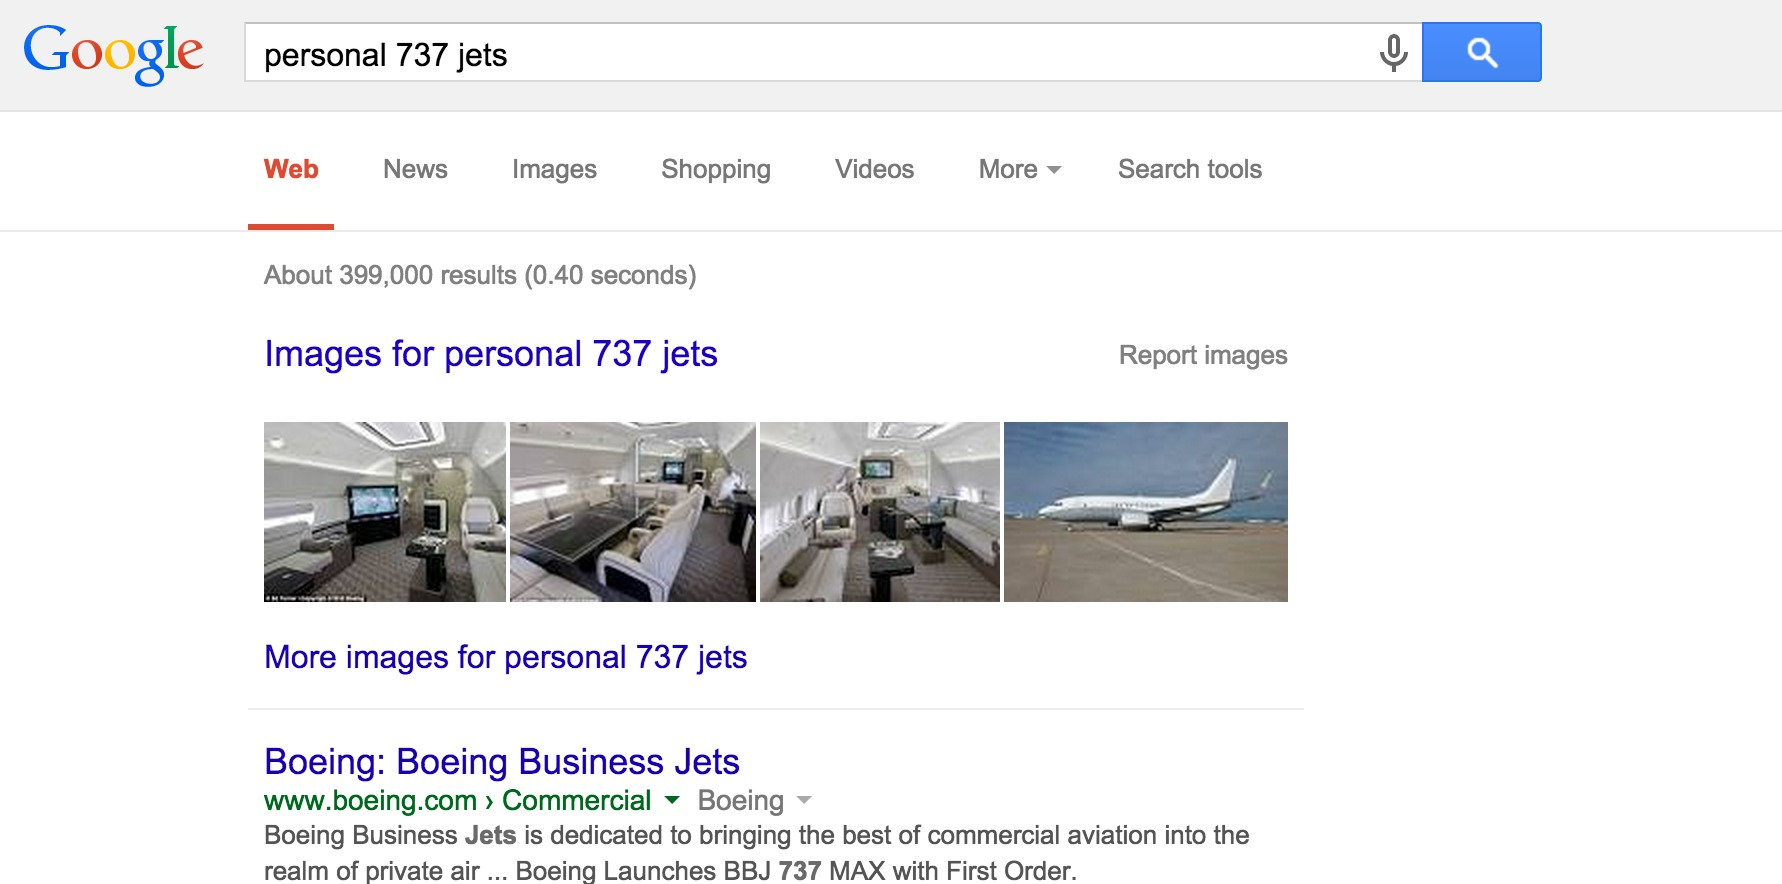

In [22]:
sl.hide_code_in_slideshow()
display(Image("images/sample-google-search.jpg", width=450))

Notice that the search returned about 400,000 results!

Recall that using Gaussian elimination to solve $A\vx = \vb$ takes about $\frac{2}{3}n^3$ operations.

In this case, apparently $n = 400,000.$  

So computing the PageRank in the straightforward way we've described would take about 42,667,000,000,000,000 operations.  

Assuming a 2GHz CPU, that's on the order of __eight months.__

In [23]:
((2./3)*(400000**3))/((2*10**9)*(3600*24*30))

8.23045267489712

We need a faster way to compute the PageRank!

Here is an important point: we only need the __principal__ eigenvector. (The one corresponding to $\lambda = 1$).

Let's review how a Markov chain gets to steady state.  As we discussed at the end of the lecture on the characteristic equation, the state of the chain at any step $k$ is given by

$${\bf x_k} = c_1{\bf v_1}\lambda_1^k + c_2{\bf v_2}\lambda_2^k + \dots + c_n{\bf v_n}\lambda_n^k.$$

Let's assume that $\lambda_1$ is the eigenvalue 1.  If the chain converges to steady sate, then we know that all eigenvalues other than $\lambda_1$ are less than 1 in magnitude.

Of course, if $|\lambda_i| < 1,$ $$\lim_{k\rightarrow\infty} \lambda_i^k = 0.$$

So:

$$\lim_{k\rightarrow\infty}{\bf x_k} = c_1{\bf v_1}.$$

Note that $c_1$ is just a constant that doesn't affect the relative sizes of the components of ${\vx_k}$ in the limit of large $k.$

This is another way of stating that the Markov chain goes to steady state __no matter what the starting state is.__

This observation suggests another way to compute the steady state of the chain:
    
1. Start from a __random__ state $\vx_0$.
2. Compute $\vx_{k+1} = A\vx_k$ for $k = 0,1,2,3,\dots$

How do we know when to stop in Step 2?  

Since we are looking for steady-state, we can stop when the difference between $\vx_{k+1}$ and $\vx_k$ is small.

This is called the __power method.__

Why is this a better method?

Keep in mind that the number of flops in matrix-vector multiplication is about $2n^2$.  

This is compared to $2/3n^3$ for solving a system (finding the eigenvector directly).

Let's say that after computing
$$\vx_1 = A \vx_0$$
$$\vx_2 = A \vx_1$$
$$\vx_3 = A \vx_2$$
$$\vx_4 = A \vx_3$$
$$\vx_5 = A \vx_4$$
$$\vx_6 = A \vx_5$$
$$\vx_7 = A \vx_6$$
$$\vx_8 = A \vx_7$$
$$\vx_9 = A \vx_8$$
$$\vx_{10} = A \vx_9$$
we find that $\vx_{10}$ is sufficiently close to $\vx_9.$ 

How much work did we do?

We did 10 matrix-vector multiplications, or $20n^2$ flops.

So the power method is $$\frac{\frac{2}{3}n^3}{20n^2} = \frac{n}{30}$$ 
times faster than the direct method.

For our example, $n/30 = 13,333$.  So this trick reduces the running time from __8 months__ down to __27 minutes.__

In [24]:
20*400000.**2/((2*10**9)*(60))

26.666666666666668

In [25]:
# Given time, talk about sparse matrix-vector multiply.
# This is linear in n, with a constant equal to average degree (say 10)
# and gets the computation down to 40 milliseconds
# but that requires explaining why P is not really dense
# (it can be expressed as a sparse matrix plus a constant matrix)
20*10*400000./((2*10**9))

0.04

This is an example of an __iterative__ method.  Iterative methods are often the preferred approach for solving linear algebra problems in the real world. 

One final thing: how exactly do we decide when to stop iterating in the power method?

One simple way is to add up the differences of the components of $\vx_{k+1}-\vx_k$:

$$ s = \sum_{i=1}^n |\vx_{k+1,i} - \vx_{k,i}| $$

and compare it to the sum of the components of $\vx_k$:

$$ d = \sum_{i=1}^n |\vx_{k,i}| $$

If $s/d$ is small (say, less than 0.001) then we can conclude that $\vx_{k+1}$ is close enough to $\vx_k$ for us to stop iterating.

So the power method is fast, making it the algorithm of choice for a company like Google.  It is also easy to implement, and easy to parallelize across multiple machines.